# VideoLLaMA3 Inference Recipes

## Section 4: Video Understanding

We here show the best recipes to understand a video with VideoLLaMA3. Specifically, we provide samples to cover the following cases:

1. Understand a `Comman Video`: We demonstrate how to effectively analyze and derive meaningful insights from common images.

2. `Temporal grounding` within a video: Learn how to accurately pinpoint absolute timestamps for specific video events.

3. Understand a `Long Video`: Explore how our model can summarize a long video with details.

### [General] Load Model and Processor

Loading the model requires approximately 15,967 MB of VRAM at BFloat16 precision. To ensure that only one GPU is used, we restrict the CUDA visible devices to GPU 0 in this example code.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from PIL import Image
from IPython.display import Markdown, clear_output, display, Video
import matplotlib.pyplot as plt

import torch
from transformers import AutoModelForCausalLM, AutoProcessor, AutoModel, AutoImageProcessor

model_path = "DAMO-NLP-SG/VideoLLaMA3-7B"
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)

/opt/lepton/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


### Set-up
Necessary imports helper functions for video frames visualization.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def sample_frames_from_video(video_path, num_frames=64):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = total_frames // num_frames
    
    frames = []
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)

        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    
    cap.release()
    return frames

def display_frames_grid(frames, grid_size=(8, 8)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(16, 10))
    
    for i, ax in enumerate(axes.flat):
        if i < len(frames):
            ax.imshow(frames[i])
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()


### 1. Understand a Common Video

Load video and display:

In [3]:
video_path = 'visuals/basketball.mp4'
display(Video(video_path, width=480, height=300))

Fill in the conversation here and get the corresponding response. For a video, we sample at a default frame rate of `1 fps`.

In [4]:
conversation = [
    {        
        "role": "user",
        "content": [
            {
                "type": "video", 
                "video": {"video_path": video_path, "fps": 1, "max_frames": 180}
            },
            {
                "type": "text", 
                "text": "Describe the video in detial."
            },
        ]
    }
]


# Single-turn conversation
inputs = processor(conversation=conversation, return_tensors="pt")
inputs = {k: v.cuda() if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
if "pixel_values" in inputs:
    inputs["pixel_values"] = inputs["pixel_values"].to(torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=256)
response = processor.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
display(Markdown(response))

The video shows a man dribbling a basketball on an outdoor court while another person shoots hoops in the background. The camera focuses on the man's feet and shoes as he dribbles the ball. He is wearing white sneakers with red accents, and the camera captures his movements from various angles. In the background, we can see another player shooting hoops, and the sound of the ball bouncing on the ground can be heard. The video seems to be taken during the daytime, with natural light illuminating the court. Overall, the video captures the action and movement of the players on the basketball court, with a focus on the details of their footwear.

### 2. Temporal Grounding within a video

In [5]:
video_path = 'visuals/cola.mp4'
display(Video(video_path, width=480, height=300))

In [6]:
conversation = [
    {        
        "role": "user",
        "content": [
            {
                "type": "video", 
                "video": {"video_path": video_path, "fps": 1, "max_frames": 180}
            },
            {
                "type": "text", 
                "text": "When did the man pour the cola into the cup? Please output the start and end timestamps."
            },
        ]
    }
]


# Single-turn conversation
inputs = processor(conversation=conversation, return_tensors="pt")
inputs = {k: v.cuda() if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
if "pixel_values" in inputs:
    inputs["pixel_values"] = inputs["pixel_values"].to(torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=256)
response = processor.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
display(Markdown(response))

The man poured the cola into the cup from 25.6 seconds to 34.6 seconds.

### 3. Long video Understanding

Due to the slow loading of long videos, we uniformly sample 64 frames and visualize them as images.

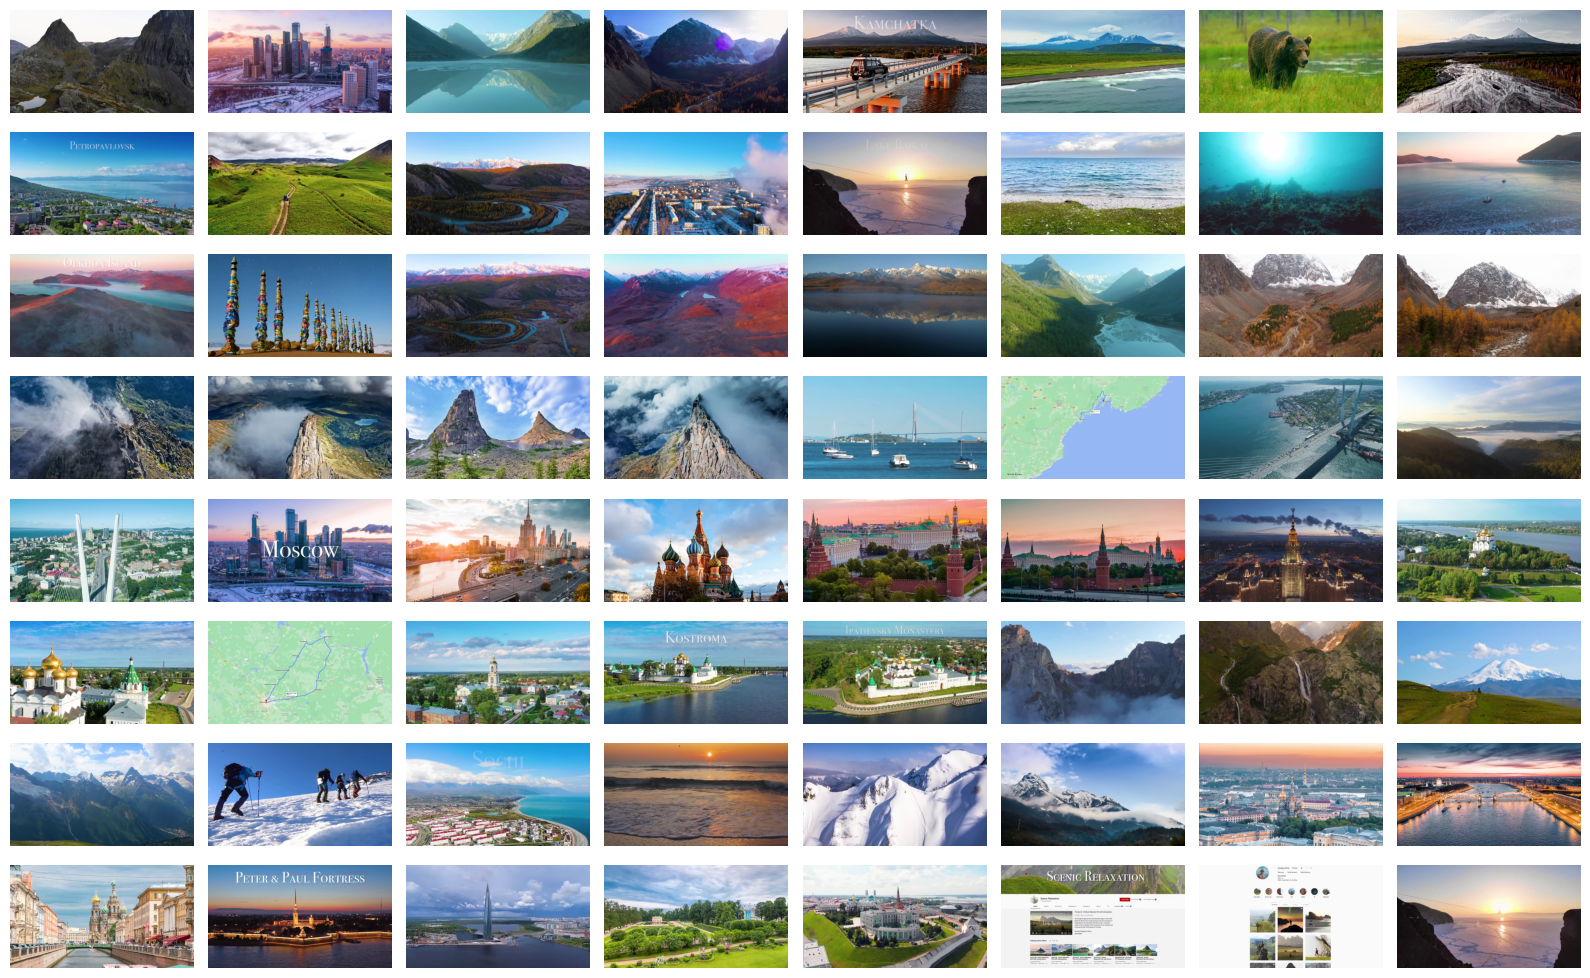

In [7]:
video_path = 'visuals/long.mp4'
frames = sample_frames_from_video(video_path, num_frames=64)
display_frames_grid(frames, grid_size=(8, 8))


In [8]:
conversation = [
    {        
        "role": "user",
        "content": [
            {
                "type": "video", 
                "video": {"video_path": video_path, "fps": 1, "max_frames": 180}
            },
            {
                "type": "text", 
                "text": "Please describe the video in detial."
            },
        ]
    }
]


# Single-turn conversation
inputs = processor(conversation=conversation, return_tensors="pt")
inputs = {k: v.cuda() if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
if "pixel_values" in inputs:
    inputs["pixel_values"] = inputs["pixel_values"].to(torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=256)
response = processor.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
display(Markdown(response))


The video shows a person bungee jumping over a frozen body of water. They are hanging from a rope and swinging back and forth above the ice. The scene is set at dusk, with the sun setting in the background. The person is suspended high above the icy surface, creating a thrilling and adventurous atmosphere.